# Multi Output GPs in GPflow

$
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\LL}{\mathcal{L}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\valpha}{\boldsymbol\alpha}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vX}{\mathbf{X}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\identity}{\mathbb{I}}
$
- $X \in \mathbb{R}^{N \times D}$ the input
- $Y \in \RR^{N \times P}$ the output
- $k_{1..L}$, $L$ kernels on $\RR^{N \times D}$
- $g_{1..L}$, $L$ independent $\GP$s  with $g_l \sim \GP(0,k_l)$
- $f_{1..P}$, $P$ correlated  $\GP$s  with $\vf = \vW \vg$ 

### Multi Output Kernels class diagram
![new_multioutput_gp_kernels.png](./new_multioutput_gp_kernels.png)




### Multi Output Features class diagram

![new_multioutput_gp_features.png](./new_multioutput_gp_features.png)

### Shape of Kuu and Kuf and the underlying conditional code depends on Mof and Mok classes used

| Feature                | Kernel                        | Kuu           | Kuf           | conditional                     | note                                                                                                                                                                                                            |
|------------------------|-------------------------------|---------------|---------------|---------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| InducingPoints         | Mok  | MxPxMxP | MxPxNxP | fully_correlated_conditional    | This is the default. Will be very inefficient for certain kernels. In this case q_mu and q_sqrt are 1 x MP and 1 x MP x MP                                                                                                                                              |
| SharedIndependentMof   | SharedIndependentMok          | M x M         | M x N         | base_conditional                | These two classes are in a sense redundant as we can achieve the same behaviour using the single output Kernel and InducingFeature classes. They are added for illustrative purposes. But thanks to the conditional dispatch the most efficient code path will be used                          |
| SeparateIndependentMof | SharedIndependentMok          | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                       |
| SharedIndependentMof   | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                 |
| SeparateIndependentMof | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                |
| SharedIndependentMof   | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | inducing outputs live in g-space                                                                                                                                                                                |
| SeparateIndependentMof | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | very similar as above                                                                                                                                                                                           |
| MixedKernelSharedMof   | SeparateMixedKernel           | L x M x M     | L x M x N     | base_conditional                 | This is the most efficient implementation for MixedKernels.  The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W. |

### Notes:
- MixedKernelSeparateMof is not implemented but can easily be added to the framework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
%matplotlib inline

import logging
gpf.multioutput.conditionals.logger.level = logging.DEBUG
gpf.multioutput.features.logger.level = logging.DEBUG

In [2]:
X = np.random.rand(100)[:, None] * 10 - 5  # N x D
G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # N x L
Ptrue = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
Y = np.matmul(G, Ptrue)  # N x P
Y += np.random.randn(*Y.shape) * [0.2, 0.2, 0.2]

D = 1  # number of input dimensions
M = 20  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

assert X.shape[1] == D and G.shape[1] == L and Ptrue.shape == (L, P) and X.shape[0] == G.shape[0] == Y.shape[0]

MAXITER = gpf.test_util.notebook_niter(int(15e1))

In [3]:
pX = np.linspace(-6, 6, 100)[:, None]

def plot_model(m):
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)

## Shared Independent MOK & Shared Independent Features (SLOW CODE)

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [4]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kernel = mk.SharedIndependentMok(gpf.kernels.RBF(D) + gpf.kernels.Linear(D), P)
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [5]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature, q_mu=q_mu, q_sqrt=q_sqrt)

DEBUG:gpflow.multioutput.conditionals:Conditional: InducingPoints -- Mok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: InducingPoints, kern: SharedIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: InducingPoints, kern: SharedIndependentMok)


In [6]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 81.063131
  Number of iterations: 151
  Number of functions evaluations: 171


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 81.063131
  Number of iterations: 151
  Number of functions evaluations: 171


DEBUG:gpflow.multioutput.conditionals:Conditional: InducingPoints -- Mok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: InducingPoints, kern: SharedIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: InducingPoints, kern: SharedIndependentMok)


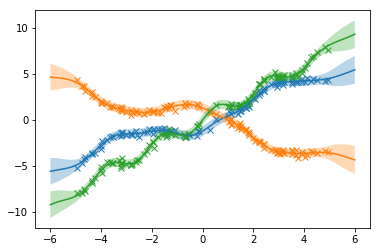

In [7]:
plot_model(m)

In [8]:
def vimshow(K):
    vmax = np.abs(K).max()
    plt.imshow(K, cmap='RdBu_r', vmin=-vmax, vmax=vmax)

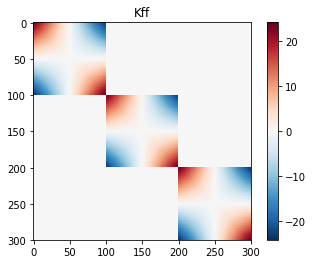

In [9]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
vimshow(np.reshape(K_trans, [100 * 3, 100*3]))
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, and the same kernel is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Shared Independent MOK & Shared Independent Features

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [10]:
gpf.reset_default_graph_and_session()

In [11]:
kernel = mk.SharedIndependentMok(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), P)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [12]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

DEBUG:gpflow.multioutput.conditionals:Conditional: SharedIndependentMof - SharedIndepedentMok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SharedIndependentMof, kern: SharedIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SharedIndependentMof, kern: SharedIndependentMok)


In [13]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 79.337823
  Number of iterations: 151
  Number of functions evaluations: 176


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 79.337823
  Number of iterations: 151
  Number of functions evaluations: 176


DEBUG:gpflow.multioutput.conditionals:Conditional: SharedIndependentMof - SharedIndepedentMok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SharedIndependentMof, kern: SharedIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SharedIndependentMof, kern: SharedIndependentMok)


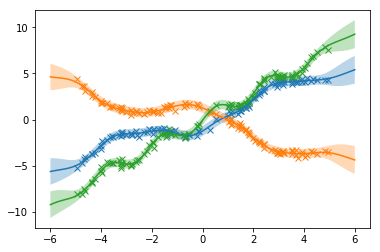

In [14]:
plot_model(m)

Again, same kernel used for each output dimension and the outputs are uncorrelated. In the `conditional`, however, we explicitly use the block-diagonal structure.

## Separate Independent MOK & Shared Independent Features (SLOW CODE)

In [15]:
gpf.reset_default_graph_and_session()

In [16]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [17]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature, q_mu=q_mu, q_sqrt=q_sqrt)

DEBUG:gpflow.multioutput.conditionals:Conditional: InducingPoints -- Mok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: InducingPoints, kern: SeparateIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: InducingPoints, kern: SeparateIndependentMok)


In [18]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 76.241836
  Number of iterations: 151
  Number of functions evaluations: 176


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 76.241836
  Number of iterations: 151
  Number of functions evaluations: 176


DEBUG:gpflow.multioutput.conditionals:Conditional: InducingPoints -- Mok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: InducingPoints, kern: SeparateIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: InducingPoints, kern: SeparateIndependentMok)


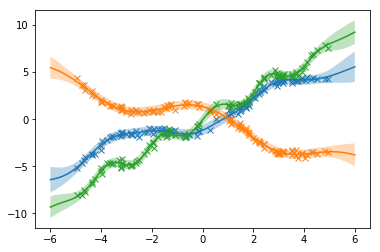

In [19]:
plot_model(m)

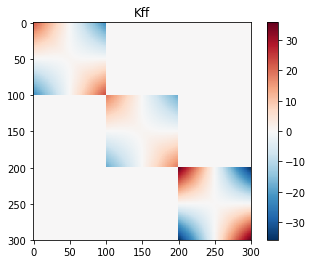

In [20]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
vimshow(np.reshape(K_trans, [100 * 3, 100*3]));
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, *but a different kernel* is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Separate Independent MOK & Shared Independent Features

In [21]:
gpf.reset_default_graph_and_session()

In [22]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [23]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

DEBUG:gpflow.multioutput.conditionals:conditional: object, SharedIndependentMof, SeparateIndependentMok, object
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SharedIndependentMof, kern: SeparateIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SharedIndependentMof, kern: SeparateIndependentMok)


In [24]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 75.998447
  Number of iterations: 151
  Number of functions evaluations: 172


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 75.998447
  Number of iterations: 151
  Number of functions evaluations: 172


DEBUG:gpflow.multioutput.conditionals:conditional: object, SharedIndependentMof, SeparateIndependentMok, object
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SharedIndependentMof, kern: SeparateIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SharedIndependentMof, kern: SeparateIndependentMok)


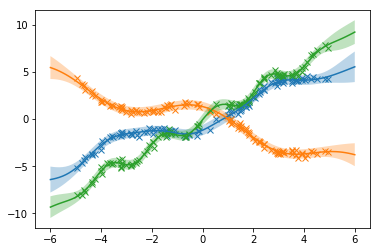

In [25]:
plot_model(m)

In [26]:
m.compute_log_likelihood()

-75.998446937421292

## Separate Independent Kernel & Separate Independent Features

In [27]:
gpf.reset_default_graph_and_session()

In [28]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature_list = [gpf.features.InducingPoints(X[np.random.permutation(len(X))[:M],...].copy()) for _ in range(P)]
feature = mf.SeparateIndependentMof(feature_list)

In [29]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

DEBUG:gpflow.multioutput.conditionals:conditional: object, SharedIndependentMof, SeparateIndependentMok, object
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SeparateIndependentMof, kern: SeparateIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SeparateIndependentMof, kern: SeparateIndependentMok)


In [30]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 78.204454
  Number of iterations: 151
  Number of functions evaluations: 180


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 78.204454
  Number of iterations: 151
  Number of functions evaluations: 180


DEBUG:gpflow.multioutput.conditionals:conditional: object, SharedIndependentMof, SeparateIndependentMok, object
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SeparateIndependentMof, kern: SeparateIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SeparateIndependentMof, kern: SeparateIndependentMok)


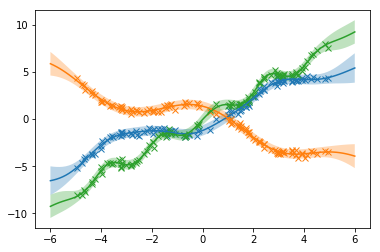

In [31]:
plot_model(m)

DEBUG:gpflow.multioutput.conditionals:conditional: object, SharedIndependentMof, SeparateIndependentMok, object
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SeparateIndependentMof, kern: SeparateIndependentMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SeparateIndependentMof, kern: SeparateIndependentMok)


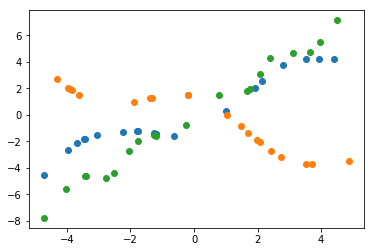

In [32]:
for i in range(len(m.feature.feat_list)):
    q_mu_unwhitenede, q_var_unwhitened = m.predict_f(m.feature.feat_list[i].Z.value)
    plt.plot(m.feature.feat_list[i].Z.value, q_mu_unwhitenede[:, [i]], "o")

This plot shows that we use different inducing *inputs* in each output dimension.

# Mixed Kernel

## 1. Mixed Kernel & Correlated features (SLOW)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
In this scenario we ignore the fact that observations are produced by mixing uncorrelated latent GPs. We directly model the correlated observations. This means that we place our inducing outputs in the $f$ space and end up with the following (large) correlation matrices.

- $ K_{uu} = M \times P \times M  \times P $
- $ K_{uf} = M \times P \times N \times P $

We'll have to use `fully_correlated_conditional` or `base_conditional` depending on the `full_cov`/`full_output_cov` args.

In [33]:
gpf.reset_default_graph_and_session()

In [34]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L))
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [35]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

DEBUG:gpflow.multioutput.conditionals:Conditional: InducingPoints -- Mok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: InducingPoints, kern: SeparateMixedMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: InducingPoints, kern: SeparateMixedMok)


In [36]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER);

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 181.615405
  Number of iterations: 151
  Number of functions evaluations: 184


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 181.615405
  Number of iterations: 151
  Number of functions evaluations: 184


DEBUG:gpflow.multioutput.conditionals:Conditional: InducingPoints -- Mok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: InducingPoints, kern: SeparateMixedMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: InducingPoints, kern: SeparateMixedMok)


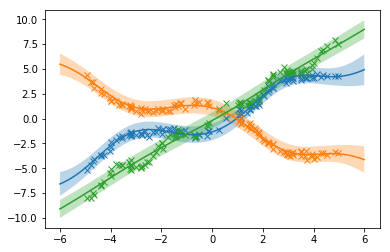

In [37]:
plot_model(m)

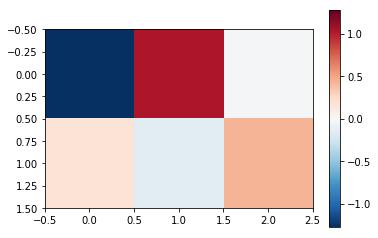

In [38]:
vimshow(m.kern.W.value.T)
plt.colorbar()

## 2. Mixed Kernel & Uncorrelated features (BETTER)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
In this scenario we assume that are inducing outputs live in the $g$ (i.e. $\mathbb{R}^L$) space.


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = M \times L \times N \times P $

We'll use `independent_latents_conditional`

In [39]:
gpf.reset_default_graph_and_session()

In [40]:
q_mu = np.zeros((M, L))
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=Ptrue.T)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [41]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

DEBUG:gpflow.multioutput.conditionals:Conditional: (SharedIndependentMof, SeparateIndepedentMof) - SeparateMixedMok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SharedIndependentMof, kern: SeparateMixedMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SharedIndependentMof, kern: SeparateMixedMok)
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SharedIndependentMof, kern: SeparateMixedMok)
DEBUG:gpflow.multioutput.conditionals:independent_interdomain_conditional


In [42]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 158.436419
  Number of iterations: 151
  Number of functions evaluations: 170


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 158.436419
  Number of iterations: 151
  Number of functions evaluations: 170


DEBUG:gpflow.multioutput.conditionals:Conditional: (SharedIndependentMof, SeparateIndepedentMof) - SeparateMixedMok
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: SharedIndependentMof, kern: SeparateMixedMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SharedIndependentMof, kern: SeparateMixedMok)
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: SharedIndependentMof, kern: SeparateMixedMok)
DEBUG:gpflow.multioutput.conditionals:independent_interdomain_conditional


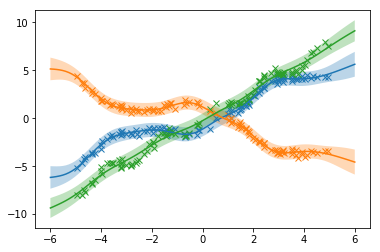

In [43]:
plot_model(m)

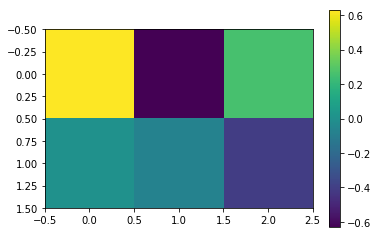

In [44]:
plt.imshow(m.kern.W.value.T)
plt.colorbar()

## 3. Mixed Kernel & Uncorrelated features (OPTIMAL)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W~\Sigma_g W^\top$


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

We'll use `base_conditional`

In [45]:
gpf.reset_default_graph_and_session()

In [46]:
q_mu = np.zeros((M, L))
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L))
feature = mf.MixedKernelSharedMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [47]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

DEBUG:gpflow.multioutput.conditionals:conditional: MixedKernelSharedMof, SeparateMixedMok
DEBUG:gpflow.multioutput.conditionals:conditional: object, SharedIndependentMof, SeparateIndependentMok, object
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: MixedKernelSharedMof, kern: SeparateMixedMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: MixedKernelSharedMof, kern: SeparateMixedMok)


In [48]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 163.438162
  Number of iterations: 151
  Number of functions evaluations: 176


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 163.438162
  Number of iterations: 151
  Number of functions evaluations: 176


DEBUG:gpflow.multioutput.conditionals:conditional: MixedKernelSharedMof, SeparateMixedMok
DEBUG:gpflow.multioutput.conditionals:conditional: object, SharedIndependentMof, SeparateIndependentMok, object
DEBUG:gpflow.multioutput.features:Dispatch to Kuu(feat: MixedKernelSharedMof, kern: SeparateMixedMok) with jitter=1e-06
DEBUG:gpflow.multioutput.features:Dispatch to Kuf(feat: MixedKernelSharedMof, kern: SeparateMixedMok)


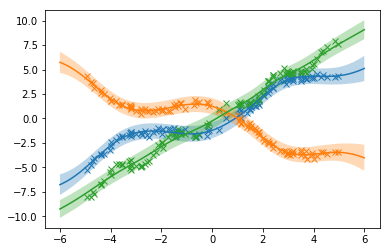

In [49]:
plot_model(m)

## 3. Mixed Kernel & Separate independent features (OPTIMAL)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W~\Sigma_g W^\top$


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

We'll use `base_conditional`

In [ ]:
gpf.reset_default_graph_and_session()

In [1]:
import numpy as np
import gpflow as gp

import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf


D = 1  # number of input dimensions
M = 20  # number of inducing points
L = 2  # number of latent GPs
P = 5  # number of observations = output dimensions

noise = 0.1

X = np.tile(np.linspace(0,1,M*2)[:,None],(1,D))
Y = np.concatenate([p*np.sin(10*X) + noise*np.random.normal(size=X.shape) for p in range(1,P+1)],axis=1)

def _kern():
    return gp.kernels.Matern32(D)
    
with gp.defer_build():

    W = np.random.normal(size=(P,L))

    kern = mk.SeparateMixedMok([_kern() for _ in range(L)], W)

    feature_list = [gp.features.InducingPoints(X[:M,:]) for l in range(L)]
    feature = mf.MixedKernelSeparateMof(feature_list)

    q_mu = np.zeros((M, L))
    q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

    likelihood = gp.likelihoods.Gaussian()
    likelihood.variance = noise
    likelihood.variance.trainable = False

    model = gp.models.SVGP(X, Y, kern, likelihood, 
                feat = feature,
                minibatch_size=None,
                num_data = X.shape[0],
                whiten=False,
              q_mu = q_mu,
              q_sqrt = q_sqrt)
    model.compile()

opt = gp.train.AdamOptimizer(1e-2)
print(model.predict_density(X,Y).mean())
opt.minimize(model, maxiter=10000)
print(model.predict_density(X,Y).mean())

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/multipledispatch-0.4.9-py3.6.egg/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


-3.4041344381903564
0.13859998443104302


In [2]:
ystar,varstar = model.predict_f(X)

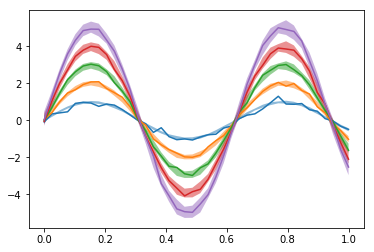

In [3]:
import pylab as plt
[plt.plot(X[:,0],Y[:,p]) for p in range(P)]
[plt.fill_between(X[:,0],ystar[:,p]-2*np.sqrt(varstar[:,p]),ystar[:,p]+2*np.sqrt(varstar[:,p]),alpha=0.5) for p in range(P)]
plt.show()

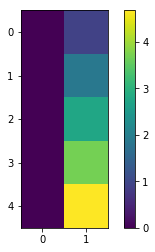

In [4]:
plt.imshow(model.kern.W.value)
plt.colorbar()
plt.show()